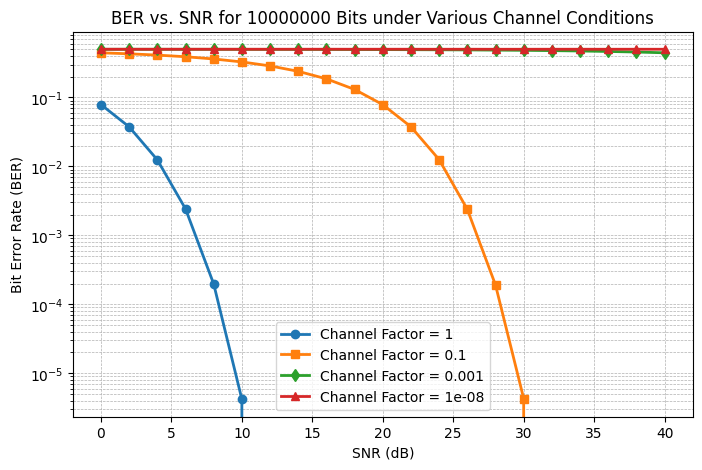

In [1]:

import numpy as np
import matplotlib.pyplot as plt


NUM_BITS = 10_000_000            # Total number of bits to simulate for each scenario

# Signal power and noise power. These values will determine the signal amplitude and noise variance.
SIGNAL_POWER = 1e-7    # The transmitted signal's power.
NOISE_POWER = 1e-7     # The baseline noise power level (will be adjusted based on SNR).

# Define a range of SNR values (in decibels) to test.
# np.arange(start, stop, step) creates an array from 0 dB to 40 dB (inclusive) in steps of 2 dB.
SNR_dB_VALUES = np.arange(0, 41, 2)

# Different channel attenuation coefficients that simulate varying channel conditions.
CHANNEL_ATTENUATIONS = [1, 0.1, 0.001, 0.00000001]


# Create a 2D array to store the computed BER values.
# Rows correspond to different channel conditions, and columns correspond to the SNR values.
ber_results = np.zeros((len(CHANNEL_ATTENUATIONS), len(SNR_dB_VALUES)))

# Define a list of plot styles to visually distinguish the BER curves for each channel condition.
PLOT_STYLES = ['o-', 's-', 'd-', '^-', 'v-', 'x-', '*-', '+-']

# =============================================================================
# Simulation Loop: Iterate over each channel condition and SNR value
# =============================================================================

# Loop over each channel attenuation scenario.
for chan_idx, channel_factor in enumerate(CHANNEL_ATTENUATIONS):
    # For each channel condition, iterate over the different SNR levels.
    for snr_idx, snr_db in enumerate(SNR_dB_VALUES):

        # -----------------------------------------------------------
        # Convert SNR from dB to Linear Scale and Compute Noise Variance
        # -----------------------------------------------------------
        # SNR (in linear scale) = 10^(SNR_dB/10)
        snr_linear = 10 ** (snr_db / 10)
        # The noise variance is calculated by scaling the fixed NOISE_POWER by the linear SNR.
        noise_variance = NOISE_POWER / snr_linear

        # -----------------------------------------------------------
        # Generate the Transmitted Bit Sequence and Corresponding Signal
        # -----------------------------------------------------------
        # Create a random binary sequence (0s and 1s) of length NUM_BITS.
        transmitted_bits = np.random.randint(0, 2, NUM_BITS)

        # Determine the amplitude (voltage) for the transmitted signal based on the signal power.
        # (Since power ∝ voltage², the voltage is the square root of the power.)
        voltage_amplitude = np.sqrt(SIGNAL_POWER)

        # Map the binary data to a BPSK signal:
        # Convention: 0 maps to a positive voltage, and 1 maps to a negative voltage.
        # This mapping is implemented using np.where.
        transmitted_signal = np.where(transmitted_bits == 0, voltage_amplitude, -voltage_amplitude)

        # -----------------------------------------------------------
        # Simulate the Channel: Apply Attenuation and Add Noise
        # -----------------------------------------------------------
        # Apply channel attenuation by scaling the transmitted signal with the channel factor.
        attenuated_signal = channel_factor * transmitted_signal

        # Generate Additive White Gaussian Noise (AWGN) with a complex representation.
        # The noise has two independent components (real and imaginary), each with variance = noise_variance/2.
        # Calculate the standard deviation of the noise from the variance.
        noise_std = np.sqrt(noise_variance)
        noise_real = (1 / np.sqrt(2)) * np.random.normal(0, noise_std, NUM_BITS)
        noise_imag = (1 / np.sqrt(2)) * np.random.normal(0, noise_std, NUM_BITS)
        # Combine the real and imaginary parts to form complex noise.
        complex_noise = noise_real + 1j * noise_imag

        # The received signal is the sum of the attenuated transmitted signal and the AWGN.
        received_signal = attenuated_signal + complex_noise

        # -----------------------------------------------------------
        # Decode the Received Signal to Recover the Bits
        # -----------------------------------------------------------
        # We decide on the transmitted bit based on the real part of the received signal.
        # If the real part is below zero, we decode the bit as 1; otherwise, as 0.
        recovered_bits = (np.real(received_signal) < 0).astype(int)

        # Count the number of errors by comparing the recovered bits to the original transmitted bits.
        num_errors = np.sum(recovered_bits != transmitted_bits)

        # Compute the Bit Error Rate (BER) as the ratio of incorrect bits to the total number of bits.
        ber_results[chan_idx, snr_idx] = num_errors / NUM_BITS


# Create a figure to display the BER vs. SNR curves.
plt.figure(figsize=(8, 5))

# Plot each channel condition's BER curve on a semilogarithmic scale (Y-axis in log scale).
for idx, channel_factor in enumerate(CHANNEL_ATTENUATIONS):
    style = PLOT_STYLES[idx % len(PLOT_STYLES)]
    # semilogy is used because BER values span several orders of magnitude.
    plt.semilogy(SNR_dB_VALUES, ber_results[idx, :], style, linewidth=2,
                 label=f'Channel Factor = {channel_factor}')

# Label the axes and add a title.
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title(f'BER vs. SNR for {NUM_BITS} Bits under Various Channel Conditions')

# Add a grid to the plot for better readability (both major and minor grid lines).
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Include a legend to identify each curve.
plt.legend()

# Render the plot to the screen.
plt.show()
